# Yashi Game

__Federico Chiarello__ - 2058163

An instance of the __Yashi game__ is specified by a _n x n_ integer grid for some _n > 2_, on
which _p > 2_ nodes are placed.

A solution of the game consists in drawing horizontal and vertical segments, satisfying the following conditions:
- No two segments cross each other
- The segments form a tree (they form a graph without cycles)

Given an instance G of __Yashi__, develop a
SAT based method to answer the following questions:
1. Decide if there is a solution for G. If
there is, return one solution.
2. Decide if there is a solution for G. If there
is, return a minimum-length solution.


## Setup

In [51]:
!pip install python-sat

In [52]:
import pysat
import math
import random
import itertools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from pysat.solvers import Minisat22
from pysat.examples.fm import FM
from pysat.formula import WCNF

### Generate Points

The following function randomly generates an instance of the __Yashi__ game.  
It creates a dictionary that contains as keys the points coordinates and as values the points ids.

In [53]:
def generate_points(n_points=10, range_points=10):

    tuples = []
    while len(tuples) < n_points:
        new_point = (random.randint(0, range_points), random.randint(0, range_points))
        if new_point not in tuples:
            tuples.append(new_point)

    sorted_tuples = sorted(tuples, key=lambda p: (p[0], p[1]))
    points_zip = zip(sorted_tuples, range(len(sorted_tuples)))
    points_dict = dict(points_zip)

    return points_dict

In [54]:
n_points = 15
range_points = 5

points_dict = generate_points(n_points, range_points)
points_dict

{(0, 0): 0,
 (0, 2): 1,
 (0, 4): 2,
 (0, 5): 3,
 (1, 1): 4,
 (1, 2): 5,
 (2, 0): 6,
 (2, 2): 7,
 (3, 0): 8,
 (3, 3): 9,
 (3, 5): 10,
 (4, 1): 11,
 (5, 1): 12,
 (5, 2): 13,
 (5, 5): 14}

### Plot Functions

In [55]:
def plot_graph(points_dict, segments_dict={}, lines_dict={}):

    x = [point[0] for point in points_dict]
    y = [point[1] for point in points_dict]
    labels = [label for label in points_dict.values()]

    # Plot points
    plt.scatter(x, y, color='red')
    for i, label in enumerate(labels):
        plt.annotate(label, (x[i], y[i]), (x[i] + 0.1, y[i] + 0.1), color='red')

    if lines_dict != {}:

        # Plot the solution
        for label, segment in lines_dict.items():
            x1, y1 = segment[0]
            x2, y2 = segment[1]
            plt.plot([x1, x2], [y1, y2], color='black')
            if x1==x2:
                plt.annotate(label, ((x1+x2)/2 + 0.1, (y1+y2)/2 - 0.1), color='black')
            else:
                plt.annotate(label, ((x1+x2)/2 - 0.1, (y1+y2)/2 + 0.1), color='black')

    else:

        # Plot all possible horizontal and vertical segments
        for label, segment in segments_dict.items():
            x1, y1 = segment[0]
            x2, y2 = segment[1]
            plt.plot([x1, x2], [y1, y2], color='black', linestyle='dashed')
            if x1==x2:
                plt.annotate(label, ((x1+x2)/2 + 0.1, (y1+y2)/2 - 0.1), color='black')
            else:
                plt.annotate(label, ((x1+x2)/2 - 0.1, (y1+y2)/2 + 0.1), color='black')

    plt.xlim(-1, range_points+1)
    plt.ylim(-1, range_points+1)
    plt.gca().set_aspect('equal')

    plt.xticks(range(0, range_points+1))
    plt.yticks(range(0, range_points+1))
    plt.grid(True)

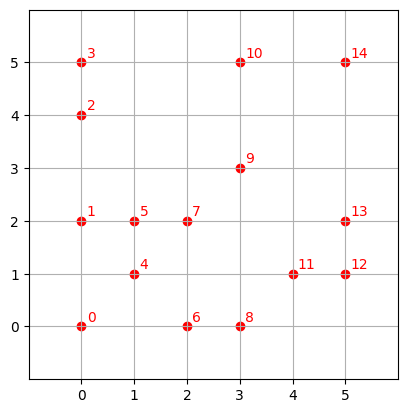

In [56]:
plot_graph(points_dict)

In [57]:
def sat_plots(points_dict, segments_dict, sat_solution):

    plt.subplot(1, 3, 1)
    plot_graph(points_dict)
    plt.title("Points")

    plt.subplot(1, 3, 2)
    plot_graph(points_dict, segments_dict)
    plt.title("Possible Segments")

    plt.subplot(1, 3, 3)
    plot_graph(points_dict, {}, sat_solution)
    plt.title("SAT Solution")

    plt.tight_layout()

    plt.show()

In [58]:
def max_sat_plots(points_dict, segments_dict, sat_solution, max_sat_solution):

    plt.subplot(1, 3, 1)
    plot_graph(points_dict, segments_dict)
    plt.title("Possible Segments")

    plt.subplot(1, 3, 2)
    plot_graph(points_dict, {}, sat_solution)
    plt.title("SAT Solution")

    plt.subplot(1, 3, 3)
    plot_graph(points_dict, {}, max_sat_solution)
    plt.title("Minimum-length Solution")

    plt.tight_layout()

    plt.show()

### Find Segments

Here we identify all the possible segments connecting the points in our game configuration.

In [59]:
def find_segments(points_dict):

    sorted_by_x = sorted(points_dict, key=lambda p: (p[0], p[1]))
    sorted_by_y = sorted(points_dict, key=lambda p: (p[1], p[0]))

    segments = []

    # Vertical segments
    for i in range(len(sorted_by_x) - 1):
        if sorted_by_x[i][0] == sorted_by_x[i+1][0]:
            segments.append((sorted_by_x[i], sorted_by_x[i+1]))

    # Horizontal segments
    for i in range(len(sorted_by_y) - 1):
        if sorted_by_y[i][1] == sorted_by_y[i+1][1]:
            segments.append((sorted_by_y[i], sorted_by_y[i+1]))

    # Create Dictionary
    segments_dict = {}
    get_idx_dict = {}
    for i in range(len(segments)):
        segments_dict[i+1] = segments[i]
        get_idx_dict[segments[i]] = i+1

    return segments_dict, get_idx_dict

In [60]:
segments_dict, get_idx_dict = find_segments(points_dict)

In [61]:
segments_dict

{1: ((0, 0), (0, 2)),
 2: ((0, 2), (0, 4)),
 3: ((0, 4), (0, 5)),
 4: ((1, 1), (1, 2)),
 5: ((2, 0), (2, 2)),
 6: ((3, 0), (3, 3)),
 7: ((3, 3), (3, 5)),
 8: ((5, 1), (5, 2)),
 9: ((5, 2), (5, 5)),
 10: ((0, 0), (2, 0)),
 11: ((2, 0), (3, 0)),
 12: ((1, 1), (4, 1)),
 13: ((4, 1), (5, 1)),
 14: ((0, 2), (1, 2)),
 15: ((1, 2), (2, 2)),
 16: ((2, 2), (5, 2)),
 17: ((0, 5), (3, 5)),
 18: ((3, 5), (5, 5))}

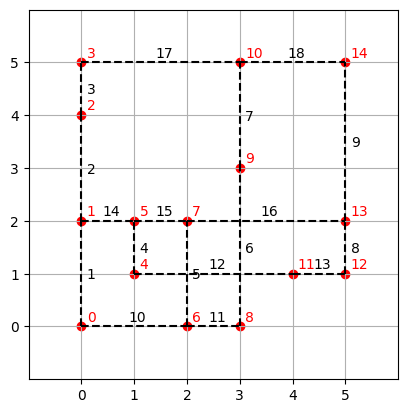

In [62]:
plot_graph(points_dict, segments_dict)

## Constraints

I used the SAT encoding proposed in this [paper](https://www.cs.bu.edu/faculty/kfoury/UNI-Teaching/CS512/AK_Documents/Modeling-with-PL/main.pdf).  
It uses the segments ids as variables and defines the game rules with the 3 following propositional formulas:

$ϕ = ϕ_{no\_crossing} \land ϕ_{no\_cycles} \land ϕ_{tree}$

The constraints that we are imposing are the following:

1. $ϕ_{no\_crossing}$ is satisfied by a truth-value assignment iff no two crossing segments are both present in the solution.
2. $ϕ_{no\_cycles}$ is satisfied by a truth-value assignment iff not all the segments that are part of a cycle are present in the solution.
3. $ϕ_{tree}$ is satisfied by a truth-value assignment iff exactly (p - 1) segments are present in the solution.

### No Crossings

If two segments are crossing, not both of them can be included in the solution.

$\phi_{no\_crossing} = CNF(\bigwedge_\limits{\substack{s_i, s_j, \\ s_i \neq s_j, \\ are\_crossing(s_i, s_j)}} \overline{s_i \land s_j}) = \bigwedge_\limits{\substack{s_i,s_j, \\ s_i \neq s_j, \\ are\_crossing(s_i, s_j)}} (\overline{s_i} \lor \overline{s_j})
$.

In [63]:
def get_crossing_segments(segments, get_idx_dict):

    def are_crossing(segment_1, segment_2):
        (x1, y1), (x2, y2) = segment_1
        (x3, y3), (x4, y4) = segment_2
        return (
            (min(x1, x2) < x3 < max(x1, x2) and min(y3, y4) < y1 < max(y3, y4)) or
            (min(y1, y2) < y3 < max(y1, y2) and min(x3, x4) < x1 < max(x3, x4))
        )

    crossing_segments = []
    for i in segments:
        for j in segments:
            if i != j:
                if are_crossing(i, j):
                    new_cross = sorted((get_idx_dict[i], get_idx_dict[j]))
                    if new_cross not in crossing_segments:
                        crossing_segments.append(new_cross)

    return crossing_segments

In [64]:
crossings = get_crossing_segments(segments_dict.values(), get_idx_dict)
crossings

[[5, 12], [6, 12], [6, 16]]

### No Cycles

In this section we identify the cycles that are present in the graph formed by all the possible segments connecting our points, after that we impose that not all the segments that are part of a cycle are present in our final solution.

$\phi_{no\_cycles} = CNF(\bigwedge_\limits{c \in cycles} \overline{\bigwedge_\limits{s \in c} s}) = \bigwedge_\limits{c \in cycles} \bigvee_\limits{s \in c} \overline{s}$

We identify the cycles with the following procedure:
- we create an adjacency list as a dictionary, with the points as keys and as values all the segmants that are adjecent to the respective point.
- we perform a depth first search exploiting the adjecency list, obtaining in this way a list of all the cycles present in the graph.

In [65]:
def generate_adjacency_list(segments_dict):
    adjacency_list = {}

    for label, segment in segments_dict.items():
        start, end = segment

        if start in adjacency_list:
            adjacency_list[start].append(end)
        else:
            adjacency_list[start] = [end]

        if end in adjacency_list:
            adjacency_list[end].append(start)
        else:
            adjacency_list[end] = [start]

    return adjacency_list

In [66]:
adjacency_list = generate_adjacency_list(segments_dict)
adjacency_list

{(0, 0): [(0, 2), (2, 0)],
 (0, 2): [(0, 0), (0, 4), (1, 2)],
 (0, 4): [(0, 2), (0, 5)],
 (0, 5): [(0, 4), (3, 5)],
 (1, 1): [(1, 2), (4, 1)],
 (1, 2): [(1, 1), (0, 2), (2, 2)],
 (2, 0): [(2, 2), (0, 0), (3, 0)],
 (2, 2): [(2, 0), (1, 2), (5, 2)],
 (3, 0): [(3, 3), (2, 0)],
 (3, 3): [(3, 0), (3, 5)],
 (3, 5): [(3, 3), (0, 5), (5, 5)],
 (5, 1): [(5, 2), (4, 1)],
 (5, 2): [(5, 1), (5, 5), (2, 2)],
 (5, 5): [(5, 2), (3, 5)],
 (4, 1): [(1, 1), (5, 1)]}

In [67]:
def find_cycles(adjacency_list):

    def depth_first_search(current, start, path):
        nonlocal cycles, sorted_cycles
        visited[current] = True
        path.append(current)
        for neighbor in adjacency_list[current]:
            if not visited[neighbor]:
                depth_first_search(neighbor, start, path)
            elif neighbor == start and len(path) > 2:
                new_cycle = path[:]
                sorted_cycle = sorted(path[:])
                if sorted_cycle not in sorted_cycles:
                    cycles.append(new_cycle)
                    sorted_cycles.append(sorted_cycle)
        path.pop()
        visited[current] = False


    nodes = adjacency_list.keys()
    visited = {}
    for node in nodes:
        visited[node] = False
    cycles, sorted_cycles = [], []

    for node in nodes:
        depth_first_search(node, node, [])

    return cycles

In [68]:
cycles = find_cycles(adjacency_list)

for cycle in cycles:
    print(cycle)

[(0, 0), (0, 2), (0, 4), (0, 5), (3, 5), (3, 3), (3, 0), (2, 0)]
[(0, 0), (0, 2), (0, 4), (0, 5), (3, 5), (5, 5), (5, 2), (5, 1), (4, 1), (1, 1), (1, 2), (2, 2), (2, 0)]
[(0, 0), (0, 2), (0, 4), (0, 5), (3, 5), (5, 5), (5, 2), (2, 2), (2, 0)]
[(0, 0), (0, 2), (1, 2), (1, 1), (4, 1), (5, 1), (5, 2), (5, 5), (3, 5), (3, 3), (3, 0), (2, 0)]
[(0, 0), (0, 2), (1, 2), (1, 1), (4, 1), (5, 1), (5, 2), (2, 2), (2, 0)]
[(0, 0), (0, 2), (1, 2), (2, 2), (2, 0)]
[(0, 0), (0, 2), (1, 2), (2, 2), (5, 2), (5, 5), (3, 5), (3, 3), (3, 0), (2, 0)]
[(0, 2), (0, 4), (0, 5), (3, 5), (3, 3), (3, 0), (2, 0), (2, 2), (1, 2)]
[(0, 2), (0, 4), (0, 5), (3, 5), (3, 3), (3, 0), (2, 0), (2, 2), (5, 2), (5, 1), (4, 1), (1, 1), (1, 2)]
[(0, 2), (0, 4), (0, 5), (3, 5), (5, 5), (5, 2), (5, 1), (4, 1), (1, 1), (1, 2)]
[(0, 2), (0, 4), (0, 5), (3, 5), (5, 5), (5, 2), (2, 2), (1, 2)]
[(1, 1), (1, 2), (2, 2), (2, 0), (3, 0), (3, 3), (3, 5), (5, 5), (5, 2), (5, 1), (4, 1)]
[(1, 1), (1, 2), (2, 2), (5, 2), (5, 1), (4, 1)]
[(2

In [69]:
def convert_cycles_into_segment_list(cycles):

    cycles_segments = []

    for cycle in cycles:
        segments_list = []

        # Get the name of the segment connecting point i and point i+1 in the cycle list
        for i in range(len(cycle)-1):
            cyc = get_idx_dict[tuple(sorted((cycle[i], cycle[i+1]), key=lambda p: (p[0], p[1])))]
            segments_list.append(cyc)

        # Repeat the procedure also for the segment connecting the first and last point in the list
        cyc = get_idx_dict[tuple(sorted((cycle[0], cycle[len(cycle)-1]), key=lambda p: (p[0], p[1])))]
        segments_list.append(cyc)

        cycles_segments.append(segments_list)

    return cycles_segments


In [70]:
cycles_segments = convert_cycles_into_segment_list(cycles)
cycles_segments

[[1, 2, 3, 17, 7, 6, 11, 10],
 [1, 2, 3, 17, 18, 9, 8, 13, 12, 4, 15, 5, 10],
 [1, 2, 3, 17, 18, 9, 16, 5, 10],
 [1, 14, 4, 12, 13, 8, 9, 18, 7, 6, 11, 10],
 [1, 14, 4, 12, 13, 8, 16, 5, 10],
 [1, 14, 15, 5, 10],
 [1, 14, 15, 16, 9, 18, 7, 6, 11, 10],
 [2, 3, 17, 7, 6, 11, 5, 15, 14],
 [2, 3, 17, 7, 6, 11, 5, 16, 8, 13, 12, 4, 14],
 [2, 3, 17, 18, 9, 8, 13, 12, 4, 14],
 [2, 3, 17, 18, 9, 16, 15, 14],
 [4, 15, 5, 11, 6, 7, 18, 9, 8, 13, 12],
 [4, 15, 16, 8, 13, 12],
 [5, 16, 9, 18, 7, 6, 11]]

### Tree


We must guarantee that exactly (p - 1) segments are present in the solution.  
We know from _Graph Theory_ that a minimum spanning tree has precisely p-1 edges, where p is the number of vertices in the graph.

\

The constraint "exactly k" is the conjunction of "at least k" and "at most k"



$\phi_{tree} = (\bigwedge_\limits{\substack{I \subseteq [n] \\ |I|=n-k+1}} \bigvee_\limits{i \in I} s_i) \land (\bigwedge_\limits{\substack{I \subseteq [n] \\ |I|=k+1}} \bigvee_\limits{i \in I} \bar{s_i})$

with:
- $k =$ number of points $ - 1$
- $n =$ number of segments



In [71]:
def exactly_k(segments, k):

    formulas = WCNF()
    n = len(segments)

    # at least k
    for sub_lists in itertools.combinations(segments, n-k+1):
        formulas.append(list(sub_lists))

    # at most k
    for sub_lists in itertools.combinations(segments, k+1):
        tmp = [-i for i in list(sub_lists)]
        formulas.append(tmp)

    return formulas

In [72]:
k = len(points_dict) - 1
ex_k = exactly_k(segments_dict.keys(), k)

### Minimum-Lenght

Here we generate the __soft constraints__ that are used to determine the minimum-length solution.  
Each segment is associated with a weight that corresponds to the negative of his length, which is computed as an euclidean distance.

In [73]:
def euclidean_distance(segment):
    x1, y1 = segment[0]
    x2, y2 = segment[1]
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)


def get_minimum_lenght_constraint(segments_dict):
    formulas = WCNF()
    for idx, segment in segments_dict.items():
        weight = -euclidean_distance(segment)
        formulas.append([idx], weight)
    return formulas

## Solver

### SAT Solver

Decide if there is a solution. If there is one, return one solution.

For this point we use a SAT Solver (_Minisat22_). We create a WCNF (weighted CNF) object containing all the hard constraints and pass it to the SAT Solver.
If the solver determines that there is a solution, that solution will be returned and plotted.

In [74]:
def find_solution(points_dict, segments_dict, get_idx_dict):

    wcnf = WCNF()

    # No Crossing Constraint

    crossings = get_crossing_segments(segments_dict.values(), get_idx_dict)

    for crossing in crossings:
        clause = [i * -1 for i in crossing]
        wcnf.append(clause)

    # Cycle Constraint

    adjacency_list = generate_adjacency_list(segments_dict)
    cycles = find_cycles(adjacency_list)
    cycles_segments = convert_cycles_into_segment_list(cycles)

    for cycle in cycles_segments:
        clause = [i * -1 for i in cycle]
        wcnf.append(clause)

    # Tree (Exactly p-1)

    k = len(points_dict) - 1

    if (k) > len(segments_dict.keys()):
        print('No solution: the number of possible segments present in the graph in not sufficient to connect all the points')
        return

    ex_k = exactly_k(segments_dict.keys(), k)

    wcnf.extend(ex_k.hard)



    # SAT Solver

    solver = Minisat22()
    solver.append_formula(wcnf.hard)
    solution = solver.solve()

    if solution:

        model = solver.get_model()
        sat_solution = {x: segments_dict[x] for x in model if x > 0}

        print('Model: ', model, '\n')

        figure(figsize=(15, 15), dpi=80)
        sat_plots(points_dict, segments_dict, sat_solution)

    else:
        print('No solution for this instance')

### MaxSAT

Decide if there is a solution for G. If there is one, return a __minimum-length__ solution.  

For this point we use a FM Solver (based on the _Fu&Malik MaxSAT algorithm_). We create a WCNF (weighted CNF) object containing all the hard constraints and the soft constraints and pass it to the MaxSAT Solver.
If there is a solution, the solver will return and plot the minimum-length solution.

In [75]:
def find_min_length_solution(points_dict, segments_dict, get_idx_dict):

    wcnf = WCNF()

    # No Crossing Constraint

    crossings = get_crossing_segments(segments_dict.values(), get_idx_dict)

    for crossing in crossings:
        clause = [i * -1 for i in crossing]
        wcnf.append(clause)

    # Cycle Constraint

    adjacency_list = generate_adjacency_list(segments_dict)
    cycles = find_cycles(adjacency_list)
    cycles_segments = convert_cycles_into_segment_list(cycles)

    for cycle in cycles_segments:
        clause = [i * -1 for i in cycle]
        wcnf.append(clause)

    # Tree (Exactly p-1)

    k = len(points_dict) - 1

    if (k) > len(segments_dict.keys()):
        print('No solution: the number of possible segments present in the graph in not sufficient to connect all the points')
        return

    ex_k = exactly_k(segments_dict.keys(), k)

    wcnf.extend(ex_k.hard)


    # SAT Solver

    solver = Minisat22()
    solver.append_formula(wcnf.hard)
    solution = solver.solve()

    if solution:

        model = solver.get_model()
        sat_solution = {x: segments_dict[x] for x in model if x > 0}

        # Minimum Lenght

        minimum_lenght_constraint = get_minimum_lenght_constraint(segments_dict)

        wcnf.extend(minimum_lenght_constraint.soft, weights=minimum_lenght_constraint.wght)

        # MaxSAT Solver

        solver = FM(wcnf, verbose=0)
        solution = solver.compute()


        print('Cost of the minimum-lenght solution: ', -sum(minimum_lenght_constraint.wght) + solver.cost)

        model = solver.model
        max_sat_solution = {x: segments_dict[x] for x in model if x > 0}

        print('Model: ', model, '\n')

        figure(figsize=(15, 15), dpi=80)
        max_sat_plots(points_dict, segments_dict, sat_solution, max_sat_solution)

    else:
        print('No solution for this instance')

### Examples

#### Example 1

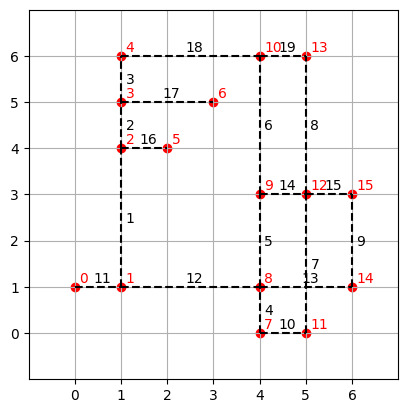

In [76]:
random.seed(3)
n_points = 16
range_points = 6

points_dict = generate_points(n_points, range_points)
segments_dict, get_idx_dict = find_segments(points_dict)

plot_graph(points_dict, segments_dict)

Model:  [1, 2, 3, 4, -5, 6, 7, 8, 9, 10, 11, 12, -13, 14, 15, 16, 17, -18, -19] 



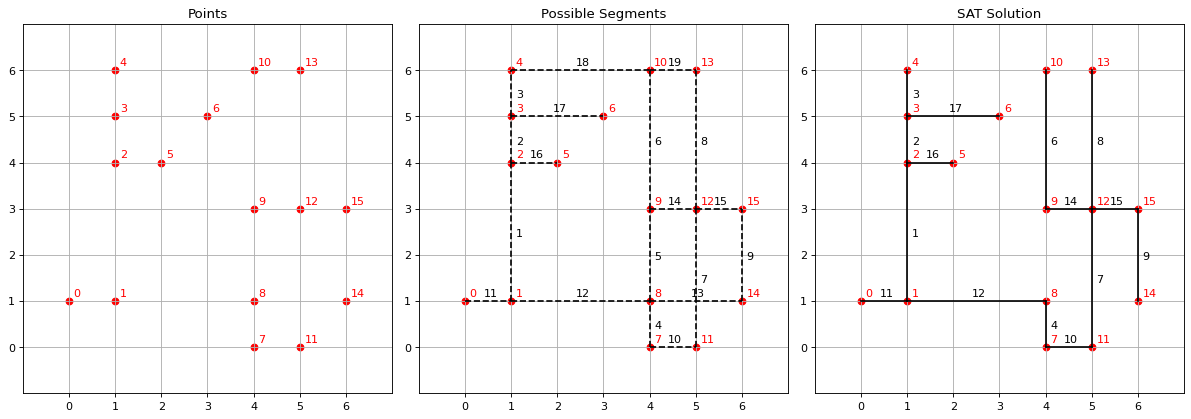

In [77]:
find_solution(points_dict, segments_dict, get_idx_dict)

Cost of the minimum-lenght solution:  24.0
Model:  [1, 2, 3, 4, 5, -6, -7, 8, -9, 10, 11, 12, 13, 14, 15, 16, 17, -18, 19] 



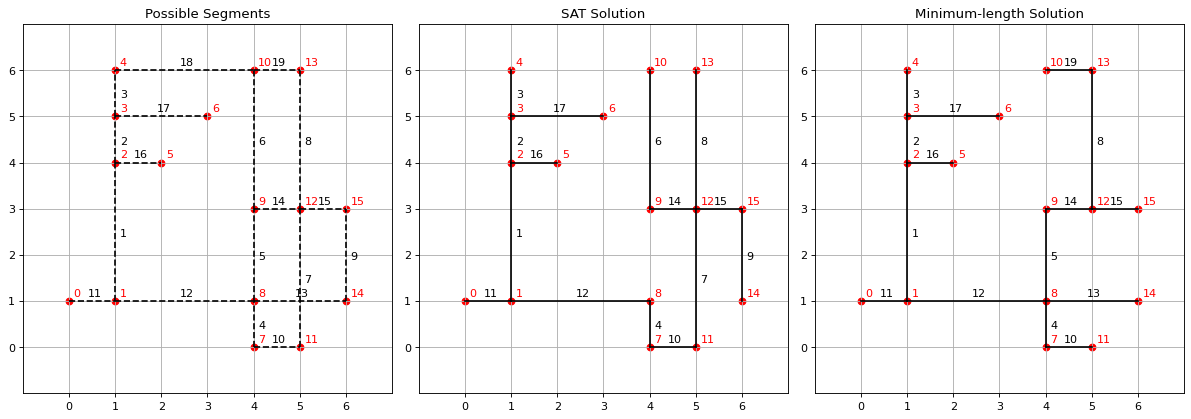

In [78]:
find_min_length_solution(points_dict, segments_dict, get_idx_dict)

#### Example 2

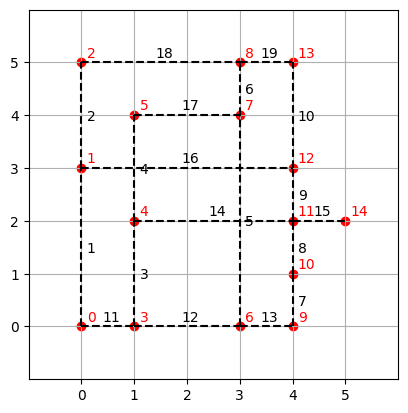

In [79]:
random.seed(30)
n_points = 15
range_points = 5

points_dict = generate_points(n_points, range_points)
segments_dict, get_idx_dict = find_segments(points_dict)

plot_graph(points_dict, segments_dict)

Model:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -14, 15, -16, -17, -18, -19] 



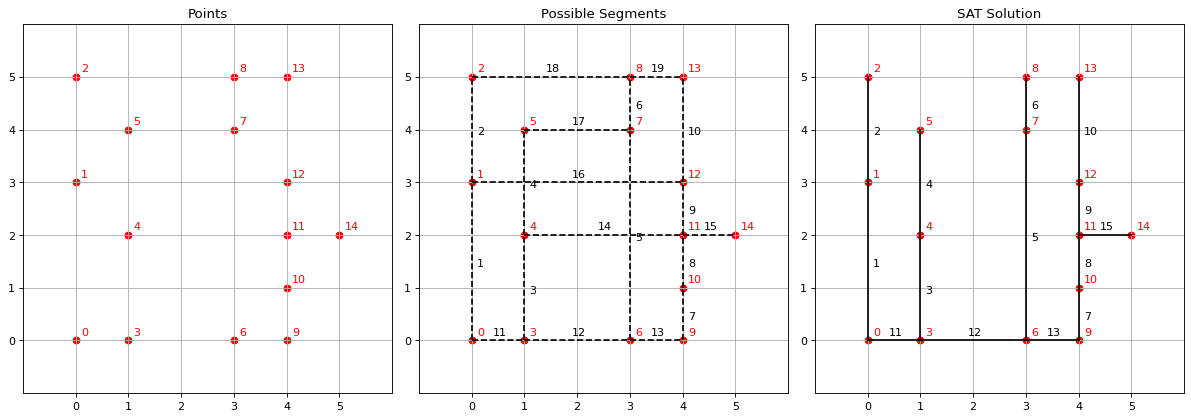

In [80]:
find_solution(points_dict, segments_dict, get_idx_dict)

Cost of the minimum-lenght solution:  21.0
Model:  [1, 2, 3, 4, -5, 6, 7, 8, 9, -10, 11, 12, 13, -14, 15, -16, 17, -18, 19] 



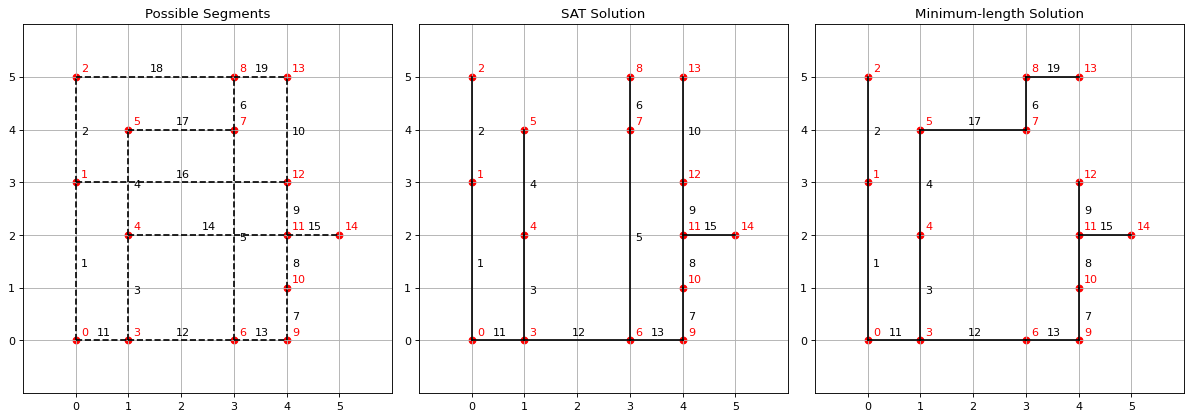

In [81]:
find_min_length_solution(points_dict, segments_dict, get_idx_dict)

#### Example 3

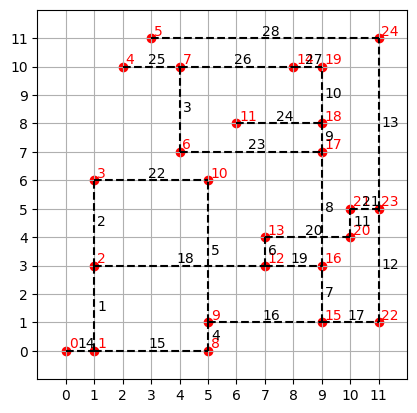

In [82]:
random.seed(6)
n_points = 25
range_points = 11

points_dict = generate_points(n_points, range_points)
segments_dict, get_idx_dict = find_segments(points_dict)

plot_graph(points_dict, segments_dict)

Model:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, -18, 19, -20, 21, -22, 23, 24, 25, -26, 27, 28] 



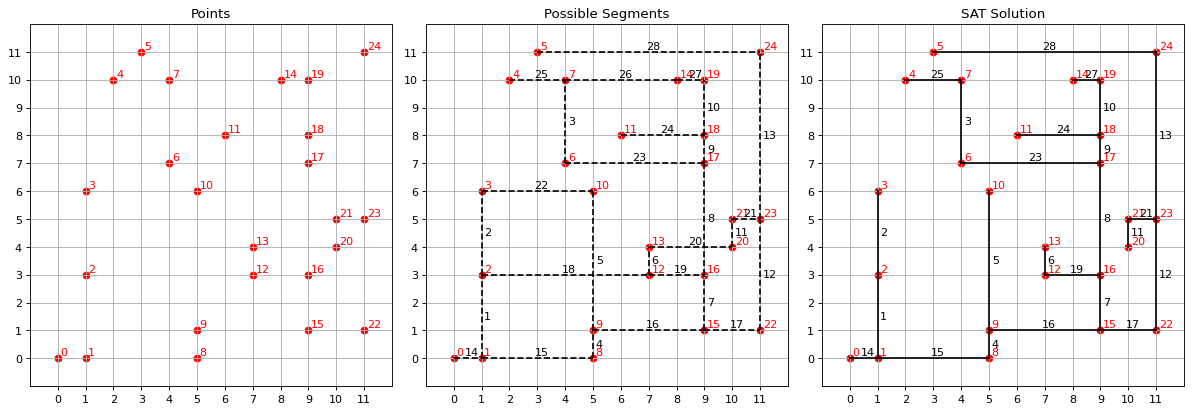

In [83]:
find_solution(points_dict, segments_dict, get_idx_dict)

Cost of the minimum-lenght solution:  68.0
Model:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, -18, 19, -20, 21, -22, -23, 24, 25, 26, 27, 28] 



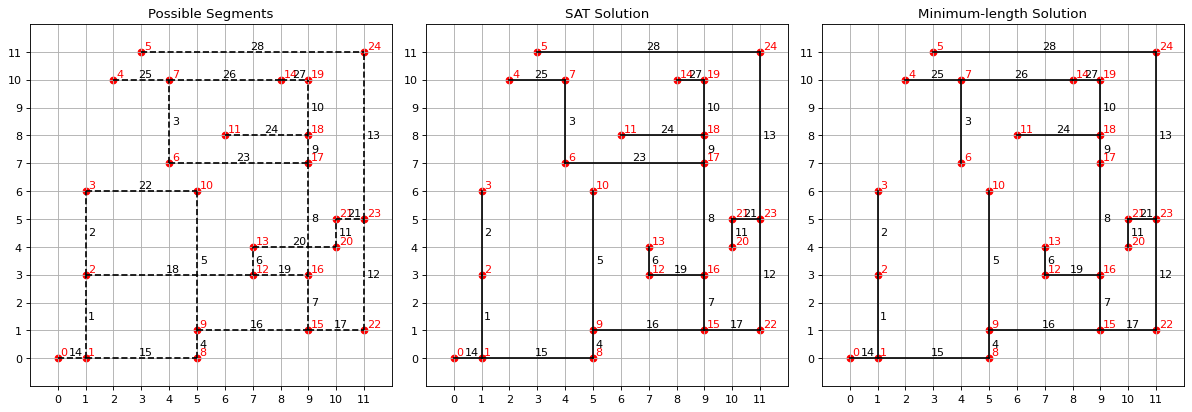

In [84]:
find_min_length_solution(points_dict, segments_dict, get_idx_dict)

#### Example 4: No Solution - Graph Not Fully Connected

In [85]:
random.seed(42)
n_points = 15
range_points = 10

points_dict = generate_points(n_points, range_points)
segments_dict, get_idx_dict = find_segments(points_dict)

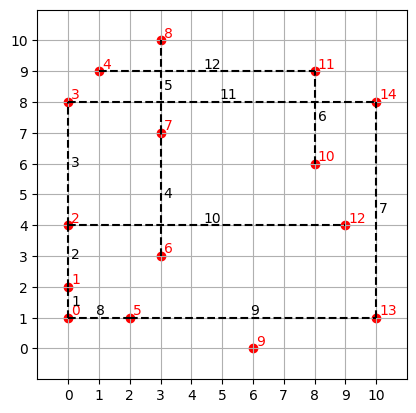

In [86]:
plot_graph(points_dict, segments_dict)

In [87]:
find_solution(points_dict, segments_dict, get_idx_dict)

No solution: the number of possible segments present in the graph in not sufficient to connect all the points


#### Example 5: No Solution - Fully Connected Graph with Crossing Segments

In [88]:
random.seed(44)
n_points = 15
range_points = 6

points_dict = generate_points(n_points, range_points)
segments_dict, get_idx_dict = find_segments(points_dict)

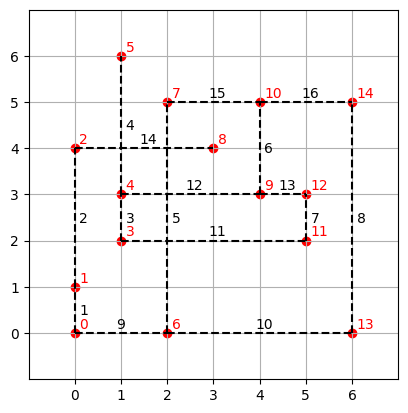

In [89]:
plot_graph(points_dict, segments_dict)

In [90]:
find_solution(points_dict, segments_dict, get_idx_dict)

No solution for this instance
